# Teste Data Science Elo7

Esse teste faz parte da segunda etapa do processo seletivo para a vaga no time Data Science do Elo7. O objetivo do teste é avaliar como você desenvolve uma solução completa (em nível de prova de conceito) para um problema de sistemas de recomendação, que é uma das tarefas que mais realizamos no nosso dia-a-dia.



# Dataset:

O conjunto de dados foi gerado em 17 de outubro de 2016 e descreve a classificação de 5 estrelas e a atividade de tags textuais da base pública do Movie Lens, um serviço de recomendação de filmes. Os dados estão contidos em seis arquivos, genome-scores.csv, genome-tags.csv, links.csv, movies.csv, ratings.csv e tags.csv. 


Estes dados contém 20.000.263 classificações e 465.564 tags em 27.278 filmes. Foram criados por 138.493 usuários entre 09 de janeiro de 1995 e 31 de março de 2015, no qual cada um deles foi selecionados aleatoriamente para inclusão. Cada funcionário selecionado pode avaliar pelo menos 20 filmes.

#### Formatação e Codificação

O conjunto de dados é separado por [comma-separated values] com apenas uma única linha de cabeçalho. Além disso, cabe destacar que esses arquivos são codificados como UTF-8

#### Ids dos Usuários

Os ids dos usuários são anônimos e consistentes entre os arquivos `ratings.csv` e `tags.csv`.

####  Ids dos Filmes

Foram incluídos nessa base de dados os filmes com pelo menos uma classificação ou tag. Os ids dos filmes são concistentes entre as bases `ratings.csv`, `tags.csv`, `movies.csv`, e `links.csv`.

####  Estrutura de arquivos de dados de classificações (ratings.csv)

Todas as classificações estão contidas no arquivo `ratings.csv`. Cada linha desse arquivo após a linha de cabeçalho representa uma avaliação de um filme por um usuário e tem o seguinte formato: `userId, movieId, classificação, timestamp`. As linhas nesse arquivo são ordenadas primeiro por `userId` e, em seguida, por `user`, e, por fim, por `movieId`. As classificações são feitas em uma escala de 5 estrelas, com incrementos de meia estrela (0,5 estrelas - 5,0 estrelas).

####  Estrutura de arquivos de dados de filmes (movies.csv)

A informação do filme está contida no arquivo `movies.csv`. Cada linha desse arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato: `movieId, título, gêneros`. Os títulos de filmes são inseridos manualmente ou importados de <https://www.themoviedb.org/> e incluem o ano de lançamento entre parênteses. 


####  Estrutura de arquivos de dados de links (links.csv)

Identificadores que podem ser usados para ligar a outras fontes de dados de filmes estão contidos no arquivo `links.csv`. Cada linha desse arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato: `movieId, imdbId, tmdbId`


####  Genoma Tag  (genome-scores.csv e genome-tags.csv)

Este conjunto de dados inclui uma cópia atual do Genoma de tags, estrutura de dados que contém pontuações de relevância de tags para filmes, de maneira a codificar a intensidade com que os filmes exibem propriedades específicas representadas por tags (atmosféricas, instigantes, realistas etc.). 

O genoma do tag foi calculado usando um algoritmo de aprendizado de máquina em conteúdo contribuído pelo usuário, incluindo tags, classificações e resenhas textuais e dividido em dois arquivos. O primeiro: `genome-scores.csv` contém dados de relevância da tag de filme no seguinte formato: `movieId, tagId, relevância`. Já o segundo arquivo: `genome-tags.csv`, fornece as descrições de tag para os IDs de tag no seguinte formato:`tagId, tag`. 

Os valores `tagId` são gerados quando o conjunto de dados é exportado, portanto eles podem variar de versão para versão dos conjuntos de dados MovieLens.

De maneira a analisar os dados deveremos agrupar as colunas dos diversos arquivos seguinto os agrupamentos do esquema abaixo:
Primeiro agrupamos os arquivos: genome-scores.csv com o geno-tag.csv pelo `tagId`. Segundo agrupamos os arquivos, genome-scores.csv, movies.csv, links.csv e ratings.csv pelo `movieId`.




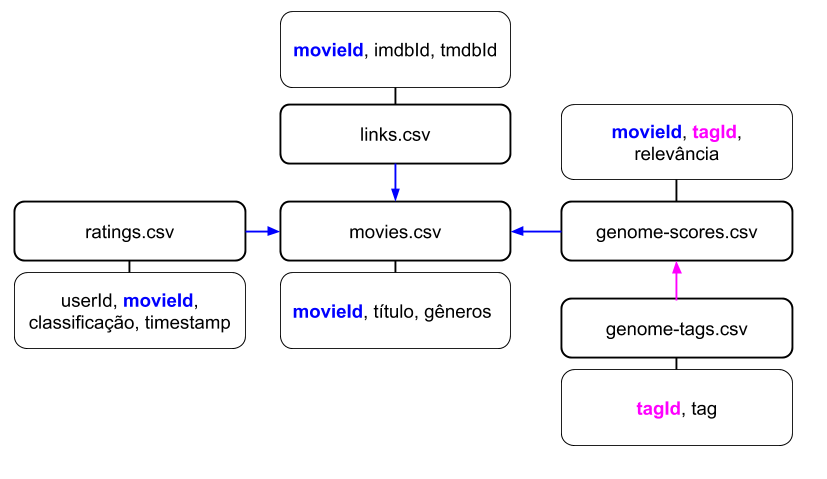

## Carregamento dos dados

In [86]:
#Bibliotecas
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import dateutil
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


In [3]:
# path = '/Users/sabrinaalvarez/Desktop/Projects/ml-20m'
path = 'C:\Users\samara.alves\Desktop\ml-20m\ml-20m'

In [4]:
movies = pd.read_csv(path + '/movies.csv', sep=',',  encoding="utf-8")

In [7]:
ratings = pd.read_csv(path + '/ratings.csv', sep=',',  encoding="utf-8", usecols=range(3))

In [5]:
display(movies.tail())

,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


Precisamos separar as colunas ano e título do filme

In [6]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year 
movies.title = movies.title.str[:-7]
display(movies.head())

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


## Agrupamento dos arquivos e Criação de tabelas

In [8]:
#Agrupamento arquivos movies e ratings
movie_rating = pd.merge(movies, ratings)

O próximo passo é agrupar a base de dados criada `movie_rating` pelo número total de votos e pela classificação média para cada um dos filmes

In [72]:
def tabel_agg(df):
    aggregations = {'rating':['count','mean']}
    new_df = df.groupby(['movieId', 'title', 'genres', 'year']).agg(aggregations)
    columns = new_df.columns.tolist()
    new_df.columns = ['n.votes','rating']
    return new_df

#### Tabela quantidade e média votos por movieId

In [73]:
tabel_agg_movieId = tabel_agg(movie_rating)
display(tabel_agg_movieId.head())

,,,,n.votes,rating
movieId,title,genres,year,,
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,49695,3.921240
2,Jumanji,Adventure|Children|Fantasy,1995.0,22243,3.211977
3,Grumpier Old Men,Comedy|Romance,1995.0,12735,3.151040
4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,2756,2.861393
5,Father of the Bride Part II,Comedy,1995.0,12161,3.064592


Vamos criar uma tabela agregada por quantidade de votos e média das classificações por ano.

In [74]:
def tabel_agg_year(df):
    aggregations = {'rating':['count','mean']}
    new_df = df.groupby(['year']).agg(aggregations)
    columns = new_df.columns.tolist()
    new_df.columns = ['n.votes','rating']
    return new_df

#### Tabela quantidade e média votos por ano de produção do filme

In [75]:
tabel_agg_year = tabel_agg_year(movie_rating)
display(tabela_agg_year.head(10))

,n.votes,mean rating
year,,
1891.0,1,3.000000
1893.0,4,3.375000
1894.0,14,3.071429
1895.0,3,2.833333
1896.0,23,3.282609
1898.0,14,3.785714
1899.0,4,3.625000
1900.0,6,3.166667
1901.0,1,5.000000


### Limpeza dados ausentes

In [14]:
print ("Numero de linhas na tabela movies com valores nulos:", max(movies.isnull().sum()))
print ("Numero de linhas na tabela ratings com valores nulos:", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    

('Numero de linhas na tabela movies com valores nulos:', 22L)
('Numero de linhas na tabela ratings com valores nulos:', 0L)


# Parte 1 - Análise Exploratória

**Questões**:

    1) Distribuição das classificações por filme e usuário
    
    2) Distribuição das classificações por ano
         
    3) Ditribuição dos gêneros dos filmes 


## Distribuição das classificações por filme e usuário

In [51]:
ratings_mean = movie_rating[['movieId','rating']].groupby('movieId').mean()

In [50]:
ratings_mean.describe()

,rating
count,26744.000000
mean,3.133200
std,0.664084
min,0.500000
25%,2.800000
50%,3.235294
75%,3.565217
max,5.000000


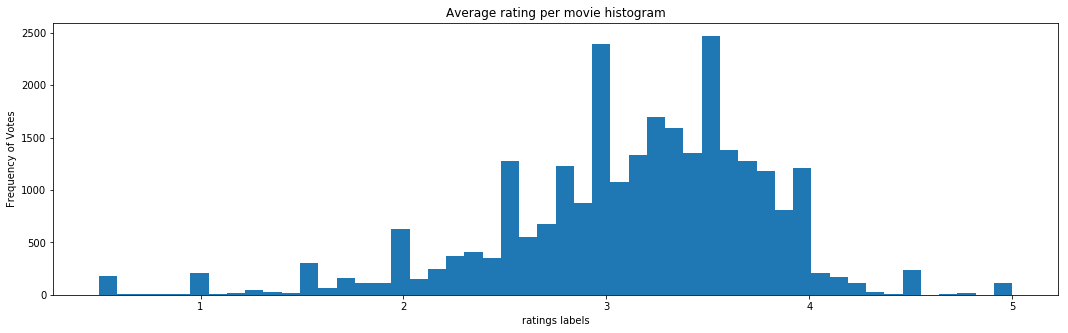

In [52]:
fig = plt.figure(figsize = (18,5))
plt.hist(ratings_mean['rating'], bins = 50)
plt.title("Average rating per movie histogram")
plt.xlabel("ratings labels")
plt.ylabel("Frequency of Votes")

fig.show()

A distribuição da média dos votos por filme apresenta uma distribuição assimétrica à esquerda o que nos indica que essas notas estão concentradas em notas mais altas e acima da mediana dos votos (3.235294). Isso pode ser explicado porque os filmes mais bem classificados são os mais recomedados ao público o que aumenta a sua média de classificação.

In [77]:
ratings_mean_user.describe()

,rating
count,138493.000000
mean,3.627209
std,0.443030
min,0.500000
25%,3.369478
50%,3.653846
75%,3.923077
max,5.000000


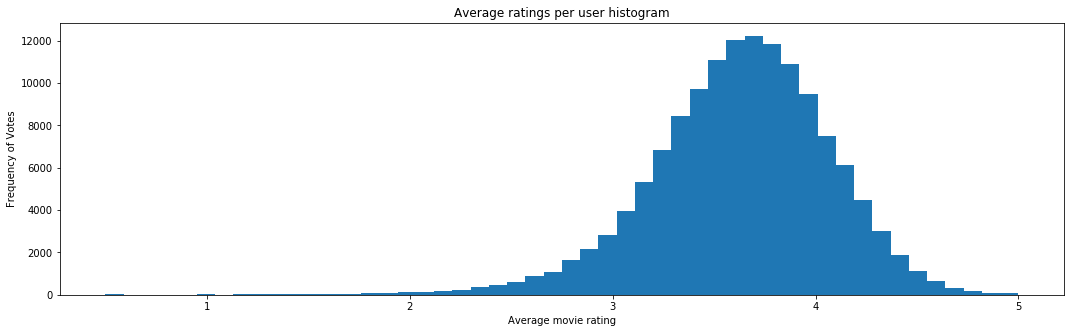

In [55]:
fig = plt.figure(figsize = (18,5))
plt.hist(ratings_mean_user['rating'], bins = 50)
plt.title("Average ratings per user histogram")
plt.xlabel("Average movie rating")
plt.ylabel("Frequency of Votes")

fig.show()

A distribuição da média dos votos por usuário apresenta uma distribuição assimétrica à esquerda assim como o gráfico anterior, contudo, a média e mediana dos votos são maiores que as observadas na tabela agrupada por filme. Enquanto que nos dados agrupados por filme a média e a mediana foram 3.133200 e 3.23529, respectivamente, a média e a mediana dos dados agrupados por usuário foram 3.627209 e 3.653846, respectivamente. Isso pode ter algumas explicações, dentre elas o fato de que o sistema de recoemdação tem uma alta taxa de acerto e indica filmes de interesse do usuário.

## Distribuição das classificações por ano

In [129]:
ratings_year = movie_rating[['year','rating']].groupby('year').mean()

In [140]:
def get_dic_year(tabel):
    dic_year = {}
    dic_year['index'] = []
    dic_year['n.votes'] = []
    dic_year['rating'] = []
    for i in range(len(tabel)):
        if str(tabel.index[i]) in :
            dic_year['index'].append(str(tabel.index[i]))
            dic_year['n.votes'].append(tabel.values[i][0])
            dic_year['rating'].append(tabel.values[i][1])

    df = pd.DataFrame(dic_year)    
    return df

In [144]:
#Selecionar apenas de 1980 a 2009
labels = ['1980.0','1981.0','1982.0','1983.0','1984.0','1985.0','1986.0','1987.0','1988.0','1989.0',
          '1990.0','1991.0','1992.0','1993.0','1994.0','1995.0','1996.0','1997.0','1998.0','1999.0',
          '2000.0','2001.0','2002.0','2003.0','2004.0','2005.0','2006.0','2007.0','2008.0','2009.0']

ratings_year_80 = get_dic_year(tabel_agg_year)
display(ratings_year_80.head())

,index,n.votes,rating
0,1980.0,216220.0,3.697121
1,1981.0,197820.0,3.691715
2,1982.0,250902.0,3.589252
3,1983.0,195069.0,3.657665
4,1984.0,335956.0,3.562401


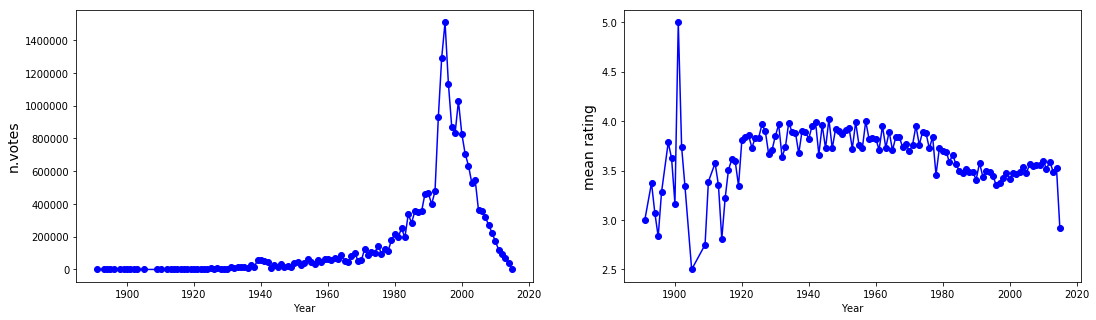

In [160]:
fig = plt.figure(figsize = (18,5))
for i, feature in enumerate(['n.votes', 'mean rating']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(tabela_agg_year[feature], "b-o")
    ax.set_ylabel("%s"%(feature), fontsize = 14)
    ax.set_xlabel('Year')
    
fig.show()

Como pode ser visto no gráfico acima, o maior volume de votos ocorreu entre os anos de 1980 e 2010. Sendo assim, de maneira a avaliar melhor a distribuição da média das classificações restringimos a base agrupada por ano para esse período.

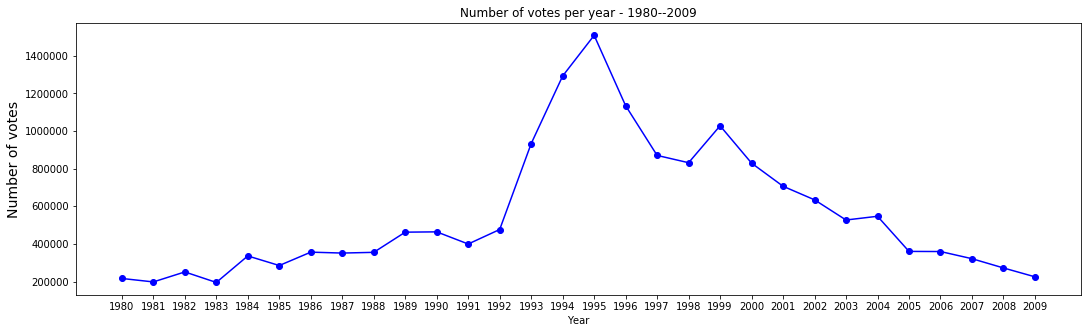

In [155]:
labels = ['1980','1981','1982','1983','1984','1985','1986','1987','1988','1989',
          '1990','1991','1992','1993','1994','1995','1996','1997','1998','1999',
          '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig = plt.figure(figsize = (18,5))
for i, feature in enumerate([ 'n.votes']):
    ax = fig.add_subplot(1, 1, i+1)
    ax.plot(ratings_year_80[feature], "b-o")
    ax.set_ylabel("Number of votes", fontsize = 14)
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
plt.title('Number of votes per year - 1980--2009')
fig.show()

In [194]:
display(movie_rating.head())

,movieId,title,genres,year,userId,rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,3,4.0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,6,5.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,8,4.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,10,4.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,11,4.5


O maior volume de classificação dos filmes da base cresceu consideravelmente a partir de 1992, atingindo a maior contagem de votos entre 1994 e 1995. Observa-se uma queda dessa votação em 1996 e um outro pico (menor que o primeiro em 1999).

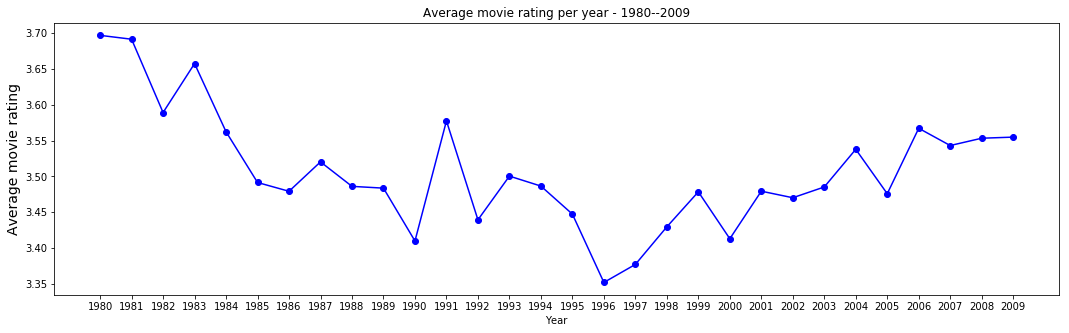

In [153]:
labels = ['1980','1981','1982','1983','1984','1985','1986','1987','1988','1989',
          '1990','1991','1992','1993','1994','1995','1996','1997','1998','1999',
          '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig = plt.figure(figsize = (18,5))
for i, feature in enumerate([ 'rating']):
    ax = fig.add_subplot(1, 1, i+1)
    ax.plot(ratings_year_80[feature], "b-o")
    ax.set_ylabel("Average movie rating", fontsize = 14)
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
#     ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')

plt.title('Average movie rating per year - 1980--2009')
fig.show()

A distribuição da média dos votos, por sua vez, apresenta um comportamente distinto do comportamento da distirbuição do número de votos. Podemos observar que em 1980 a média das classificações foi 3.70, depois disso a média das notas passa a apresentar uma tendência de queda até 1990 onde ocorre um ciclo de novo crescimento. A menor pontuação ocorre em 1196 (média próxima de 3.35). Após esse maior vale observamos um novo ciclo de alta mais significativo até o final da base em 2009.

# Parte 2 - Sistema de Recomendação

O objetivo das técnicas de Sistemas de Recomendação é recomendar itens relevantes para usuários, com base em suas preferências. A preferência e a relevância são subjetivas e geralmente são inferidas por itens que os usuários consumiram anteriormente.

As principais técnicas são:

**Filtragem Colaborativa:** Este método faz previsões automáticas (filtragem) sobre os interesses de um usuário, coletando preferências ou utilizando informações de outros usuários. O pressuposto dessa abordagem é que, se uma pessoa A tiver a mesma opinião que uma pessoa B em um conjunto de itens, A terá maior probabilidade de ter a opinião de B para um determinado item do que a de uma pessoa escolhida aleatoriamente.

**Filtragem Baseada em Conteúdo:** Este método usa apenas informações sobre a descrição e os atributos dos itens que os usuários já consumiram para modelar as preferências do usuário. Em outras palavras, esses algoritmos tentam recomendar itens semelhantes aos que um usuário gostou no passado (ou está examinando no presente). Em particular, vários itens candidatos são comparados com itens previamente classificados pelo usuário e os itens de melhor correspondência são recomendados.

**Métodos híbridos:** Pesquisas recentes demonstraram que uma abordagem híbrida, combinando filtragem colaborativa e filtragem baseada em conteúdo, poderia ser mais eficaz do que abordagens puras em alguns casos. 

Referência: https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101

## Modelo de benchmark

Primeiro definiremos um sistema de recomendação simples que possa ser generalizado para todos os usuários, no qual exibiremos os filmes com as melhores classificações por gênero. Esse modelo não leva em consideração as preferências do usuário, ele apenas considera que filmes mais bem classificados (populares) serão melhores aceitos como recomendações.

Referência: https://www.quora.com/How-does-IMDbs-rating-system-work

Podemos observar pela tabela abaixo que a média geral dos ratings é 3.5255.

In [33]:
# Estatística Descritiva da base de dados 
movie_rating['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

O primeiro código de recomendação classificará os filmes apenas pela valor ponderado de W, fórmula de classificação ponderada do IMDB:

$$W = (\frac{v}{v+m})R + (\frac{m}{v+m})C$$

onde:  
   - R: classificação média do filme
   - C: classificação média geral 
   - v: quantidade de votos do filme
   - m: quantidade mínima de votos para entrar na lista de recomendação. 
   
Definimos ser o valor de m o percentil 95% das classificações.

In [279]:
def indice_W(df, quantile):
    W = []
    C = np.mean(df['mean rating'])
    m = df.quantile(quantile)[0]
    index_list = df.index.values
    for index in index_list:
        R = df['mean rating'][index]
        v = df['n.votes'][index]
        frac1 = v/(v + m)
        frac2 = m/(v + m)
        W.append(frac1 * R + frac2 * C)
    return W

In [280]:
quantile = 0.95
W = indice_W(tabel_agg_movieId, quantile)
tabel_agg_movieId['W'] = W
tabela1_top = tabel_agg_movieId.sort_values(by=['W'], ascending=False)

Abaixo podemos verificar a lista dos 10 filmes mais bem cassificados pelos usuários na base de dados. 

In [281]:
display(tabela1_top.head(10))

,movieId,n.votes,mean rating,title,genres,year,imdbId,tmdbId,W
315,318,63366,4.446990,"Shawshank Redemption, The",Crime|Drama,1994.0,111161,278.0,3.580640
293,296,67310,4.174231,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994.0,110912,680.0,3.501996
587,593,63299,4.177057,"Silence of the Lambs, The",Crime|Horror|Thriller,1991.0,102926,274.0,3.488460
523,527,50054,4.310175,Schindler's List,Drama|War,1993.0,108052,424.0,3.474235
49,50,47006,4.334372,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,114814,629.0,3.465923
257,260,54502,4.190672,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi,1977.0,76759,11.0,3.458462
352,356,66172,4.029000,Forrest Gump,Comedy|Drama|Romance|War,1994.0,109830,13.0,3.447061
2486,2571,51334,4.187186,"Matrix, The",Action|Sci-Fi|Thriller,1999.0,133093,603.0,3.444104
843,858,41355,4.364732,"Godfather, The",Crime|Drama,1972.0,68646,238.0,3.443661
1171,1196,45313,4.188202,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Sci-Fi,1980.0,80684,1891.0,3.417748


Podemos melhorar o algoritmo e recomendar os melhores filmes da base por gênero. Para isso, criaremos tabelas com os filmes por gênero e só depois disso calcularemos a média ponderada W. 

Os filmes são classicados nas categorias: 
* Ação, Aventura, Animação, Crianças, Comédia, Crime, Documentário, Drama, Fantasia, Film-Noir, Horror, Musical, Mistério, Romance, Ficção científica, Suspense,  Guerra, Ocidental e (sem gêneros listados).

Contudo, cabe esclarecer que essas classificações são combinadas e ao todos podemos observar um total de 1.342 gêneros. Sendo assim, para criar as novas tabelas verificaremos se o gênero de interesse está incluído na classificação do filme.

In [282]:
print 'Total de classificação dos filmes: {}'.format(len(movies['genres'].value_counts()))

Total de classificação dos filmes: 1342


In [283]:
def genres_dic_list(df, genre):
    genres_dic = df['genres'].value_counts().to_dict()
    genres_dic.keys()
    list_genre = []
    for genre_index in genres_dic.keys():
        if genre in genre_index:
            list_genre.append(str(genre_index))
    return list_genre

Abaixo podemos observar a lista de classificações que incluem o gênero de interesse. 

In [284]:
genre = 'Musical'
list_genre = genres_dic_list(movies, genre)
print 'Total da lista de classificações dos filmes que incluem o gênero {}: {}'.format(genre, len(list_genre))

Total da lista de classificações dos filmes que incluem o gênero Musical: 175


In [285]:
def get_tabel_geners(list_genre, df, genre):
    frame = []
    for index in list_genre: 
        #selecionar apenas as linhas da tabela relacionadas ao genero de interesse
        row = (df['genres'] == index)
        new_df = df[row]
        frame.append(new_df)
    return frame

Abaixo temos uma tabela que aggrega os dados da tabela gerada `movie_rating` por gênero de interesse, quantidade e média de votos  


In [286]:
frame = get_tabel_geners(list_genre, tabel_agg_movieId, genre)
tabela_agg_genres = pd.concat(frame)

Por fim, calculamos as médias das classificações ponderadas por W.

In [287]:
quantile = 0.95
W = indice_W(tabela_agg_genres, quantile)
tabela_agg_genres['W'] = W
tabela_genres_top = tabela_agg_genres.sort_values(by=['W'], ascending=False)

##### Top 10 filmes Musicais

In [288]:
display(tabela_genres_top.head(10))

,movieId,n.votes,mean rating,title,genres,year,imdbId,tmdbId,W
360,364,38991,3.779090,"Lion King, The",Adventure|Animation|Children|Drama|Musical|IMAX,1994.0,110357,8587.0,3.335802
902,919,23445,3.981681,"Wizard of Oz, The",Adventure|Children|Fantasy|Musical,1939.0,32138,630.0,3.320046
582,588,41842,3.680871,Aladdin,Adventure|Animation|Children|Comedy|Musical,1992.0,103639,812.0,3.317361
589,595,35138,3.673302,Beauty and the Beast,Animation|Children|Fantasy|Musical|Romance|IMAX,1991.0,101414,10020.0,3.299050
1052,1073,28335,3.709935,Willy Wonka & the Chocolate Factory,Children|Comedy|Fantasy|Musical,1971.0,67992,252.0,3.288340
1194,1220,19824,3.804782,"Blues Brothers, The",Action|Comedy|Musical,1980.0,80455,525.0,3.275431
547,551,20509,3.731849,"Nightmare Before Christmas, The",Animation|Children|Fantasy|Musical,1993.0,107688,9479.0,3.266910
882,899,10219,4.080879,Singin' in the Rain,Comedy|Musical|Romance,1952.0,45152,872.0,3.256987
1016,1035,14049,3.804434,"Sound of Music, The",Musical|Romance,1965.0,59742,15121.0,3.251231
1009,1028,14096,3.732406,Mary Poppins,Children|Comedy|Fantasy|Musical,1964.0,58331,433.0,3.243415


Podemos ainda recomendar os melhores filmes com base no ano de produção. O cálculo desse ranking segue a mesma ideia da classificação por gênero de filme.


In [296]:
quantile = 0.95
W = indice_W(tabela_agg_year, quantile)
tabela_agg_year['W'] = W
tabela_agg_year_top = tabela_agg_year.sort_values(by=['W'], ascending=False)

##### Top 10 filmes por Ano de Produção

In [297]:
display(tabela_agg_year_top.head(10))

,n.votes,mean rating,W
year,,,
1975.0,145945,3.881493,3.674137
1972.0,88152,3.953387,3.668035
1974.0,101840,3.893721,3.665723
1977.0,126532,3.839989,3.664510
1954.0,64891,3.990345,3.663335
1962.0,71501,3.950847,3.662605
1964.0,87195,3.893153,3.662057
1957.0,55155,4.000399,3.660388
1967.0,82044,3.843115,3.656295


## Filtragem Colaborativa 

O primeiro modelo a ser implementado será o de recomendação colaborativa (explicado anteriormente). Usaremos uma biblioteca Surprise que faz uso de algoritmos SVD (Singular Value Decomposition) que minimizar o RMSE (Root Mean Square Error) de maneira a gerar as recomendações de filmes coletando preferências ou utilizando recomedações de outros usuários.